<a href="https://colab.research.google.com/github/yuukimotai/GA4_QABot/blob/main/GA4_QA_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/nlp_dataset/parsed_texts/" #GA4関連のHTMLパースしたテキスト

In [ ]:
!pip3 install datasets

In [ ]:
from datasets import load_dataset

In [ ]:
!pip3 install fugashi ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 70.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 34.9 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=a142b1a1439dd9a3e8cdc788f912761ba82417e8a8dbf90bd7b2afa38d9a69d2
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


In [ ]:
from transformers import BertForQuestionAnswering, BertJapaneseTokenizer
import torch

context = "アナリティクス 360 で企業向け機能を利用するアナリティクス 360 は Google アナリティクス 4 プロパティを基盤とし、より多くのカスタマイズ、大きな規模、企業レベルのサポートによって大規模な広告主や広告代理店の測定ニーズに対応します。"
question = "アナリティクス360の特徴は何がありますか？"
model_name = "cl-tohoku/bert-base-japanese"
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)
inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
outputs = model(**inputs)
answer_start_scores = outputs.start_logits
answer_end_scores = outputs.end_logits

answer_start = torch.argmax(answer_start_scores)
answer_end = torch.argmax(answer_end_scores) + 1
answer = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
print("Q: ", question)
print()
print("A: ", answer)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Q:  アナリティクス360の特徴は何がありますか？

A:  大 規模 な 広告 主 や 広告


In [ ]:
!pip3 install unidic_lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 36.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic_lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658818 sha256=27edf19a43caddc68cb05c0dbd35748ba42208ef3f8229566ef2ce2ab1e94e35
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic_lite


In [ ]:
from transformers import BertForQuestionAnswering, BertJapaneseTokenizer
import torch

context = "アナリティクス 360 で企業向け機能を利用するアナリティクス 360 は Google アナリティクス 4 プロパティを基盤とし、より多くのカスタマイズ、大きな規模、企業レベルのサポートによって大規模な広告主や広告代理店の測定ニーズに対応します。"
question = "アナリティクス360の特徴は何ですか？"
model_name = "cl-tohoku/bert-base-japanese-v2"
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)
inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
outputs = model(**inputs)
answer_start_scores = outputs.start_logits
answer_end_scores = outputs.end_logits

answer_start = torch.argmax(answer_start_scores)
answer_end = torch.argmax(answer_end_scores) + 1
answer = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
print("Q: ", question)
print()
print("A: ", answer)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Q:  アナリティクス360の特徴は何ですか？

A:  


In [ ]:
from transformers import BertForQuestionAnswering, BertJapaneseTokenizer
import torch

context = "アナリティクス 360 で企業向け機能を利用するアナリティクス 360 は Google アナリティクス 4 プロパティを基盤とし、より多くのカスタマイズ、大きな規模、企業レベルのサポートによって大規模な広告主や広告代理店の測定ニーズに対応します。"
question = "アナリティクス360の特徴って何ですか？"
model_name = "cl-tohoku/bert-base-japanese-v3"
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)
inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
outputs = model(**inputs)
answer_start_scores = outputs.start_logits
answer_end_scores = outputs.end_logits

answer_start = torch.argmax(answer_start_scores)
answer_end = torch.argmax(answer_end_scores) + 1
answer = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
print("Q: ", question)
print()
print("A: ", answer)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Q:  アナリティクス360の特徴って何ですか？

A:  [CLS] アナリティクス 360 の 特徴 って 何 です か ? [SEP] アナリティクス 360 で 企業 向け 機能 を 利用 する アナリティクス 360 は Google アナ リティクス 4 プロパティ を 基盤 と


In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

question = 'アナリティクス360の特徴は何がありますか？'
context = 'アナリティクス 360 で企業向け機能を利用するアナリティクス 360 は Google アナリティクス 4 プロパティを基盤とし、より多くのカスタマイズ、大きな規模、企業レベルのサポートによって大規模な広告主や広告代理店の測定ニーズに対応します。'

model = AutoModelForQuestionAnswering.from_pretrained(
    'SkelterLabsInc/bert-base-japanese-jaquad')
tokenizer = AutoTokenizer.from_pretrained(
    'SkelterLabsInc/bert-base-japanese-jaquad')

inputs = tokenizer(
    question, context, add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
outputs = model(**inputs)
answer_start_scores = outputs.start_logits
answer_end_scores = outputs.end_logits

answer_start = torch.argmax(answer_start_scores)

answer_end = torch.argmax(answer_end_scores) + 1

answer = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
print("Q: ", question)
print()
print("A: ", answer)

Q:  アナリティクス360の特徴は何がありますか？

A:  企業 向け 機能 を 利用 する アナリティクス 360 は Google アナリティクス 4 プロパティ を


# 転移学習用区画

In [ ]:
with open(path + 'ga4_parsed_analytics360.txt', 'w') as f:
  for sentence in parsed_texts:
    sentence = sentence.replace('。', '/n')
    if sentence != "":
      f.writelines(sentence)


In [ ]:
with open(path + 'ga4_parsed_analytics360.txt', 'r') as f:
  parsed_texts = f.readlines()
parsed_texts

['アナリティクス360はGoogleアナリティクス4プロパティを基盤とし、より多くのカスタマイズ、大きな規模、企業レベルのサポートによって大規模な広告主や広告代理店の測定ニーズに対応します\n',
 'アナリティクス360はGoogleアナリティクスの有料のエンタープライズ版です\n',
 'アカウント構造の柔軟性が向上しました。\n',
 'ビジネス向けの設定オプションが増加アナリティクス360では、アナリティクスデータを最適化するため、サブプロパティと統合プロパティという2つの方法が追加されました\n',
 'サブプロパティ：サブプロパティは、参照元プロパティと呼ばれる他のプロパティから（サブプロパティの）データを取得します サブプロパティのデータは通常、その参照元プロパティのデータのサブセットです\n',
 '統合プロパティ：統合プロパティには、複数の参照元プロパティからのデータが含まれます。通常のプロパティとサブプロパティのデータを含めることはできますが、他の統合プロパティのデータを含めることはできません\n',
 'サブプロパティを使用する場合\n',
 'データガバナンス：サブプロパティの最大のユースケースはデータガバナンスです。\n',
 'データガバナンスは、プロパティに含めるデータまたは除外するデータを管理する目的で使われます。サブプロパティを使用すると、データを含めたり除外したりすることで、特定のオーディエンスまたはユースケースに必要なデータセットを作成することができます。こうしてデータを適切に整理することにより、特定のオーディエンスがデータに簡単にアクセスできるようになります。\n',
 'ユーザーガバナンス：サブプロパティを使用する別のユースケースは、ユーザーガバナンスです。\n',
 'ユーザーガバナンスは、会社に厳格なポリシーがあり、特定の地域に関連するデータのサブセットを同じ地域（北米）からはアクセスできても、別の地域（南アメリカ）からはアクセスを禁止する場合です。これはサブプロパティに最適なユースケースです。各地域のデータはそのプロパティ内に制限されるため、適切な地域の外からはアクセスできなくなります。\n',
 '統合プロパティを使用する場合:製品、ブランド、地域の組み合わせ統合プロパティでは、複数の参照元プロパティのデータを1つ

In [ ]:
with open(path + 'ga4_parsed_analytics360.txt', 'w') as f:
  for sentence in sentence_list:
    f.writelines(sentence)

In [3]:
squad_path = "/content/drive/MyDrive/nlp_dataset/ga4_squad/"

In [ ]:
import json

with open(squad_path + "analytics360.json", "a", encoding='utf-8') as f:
  for i in range(len(parsed_texts)):
      data = {
          "context": parsed_texts[i],
          "question": "",
          "answers": {
              "text": [],
              "answer_start": []
          }
      }
      json.dump(data, f, indent=4, ensure_ascii=False)

In [111]:
target ="[BigQueryExport 標準アナリティクスのプロパティ]: 数十億イベント"
result = target.find("数十")
result

34

In [113]:
!pip3 install fugashi ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 102.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 28.1 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=c618311dcc3d59c329f16735118ba11ffc76d93fc094c861a3201d1bd910b4a1
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


In [24]:
from transformers import AutoTokenizer
import pandas as pd

model_name = "nlp-waseda/roberta-base-japanese"
tokenizer = AutoTokenizer.from_pretrained(model_name)
data = pd.read_json(squad_path + "analytics360.json")
data

tokenizer_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/810k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


,context,question,answers
0,アナリティクス360はGoogleアナリティクス4プロパティを基盤とし、より多くのカスタマイ...,アナリティクス360ってどんなものですか？,{'text': ['Googleアナリティクス4プロパティを基盤とし、大規模な広告主や広告...
1,アナリティクス360はGoogleアナリティクスの有料のエンタープライズ版です,アナリティクス360は無料で使えますか？,"{'text': ['有料のエンタープライズ版です'], 'answer_start': [..."
2,アカウント構造の柔軟性が向上し、ビジネス向けの設定オプションが増加しました。,アナリティクス360で良くなった点は何ですか？,{'text': ['アカウント構造の柔軟性が向上し、ビジネス向けの設定オプションが増加しま...
3,アナリティクス360では、アナリティクスデータを最適化するため、サブプロパティと統合プロパテ...,アナリティクスに追加されたものは何ですか？,"{'text': ['サブプロパティと統合プロパティ'], 'answer_start': ..."
4,サブプロパティは、参照元プロパティと呼ばれる他のプロパティから（サブプロパティの）データを取...,サブプロパティって何ですか？,{'text': ['参照元プロパティと呼ばれる他のプロパティから（サブプロパティの）データ...
5,統合プロパティには、複数の参照元プロパティからのデータが含まれます。通常のプロパティとサブプ...,統合プロパティって何ですか？,"{'text': ['複数の参照元プロパティからのデータが含まれます。'], 'answer..."
6,データガバナンス：サブプロパティの最大のユースケースはデータガバナンスです。,データガバナンスの使い方って何ですか？,"{'text': ['データガバナンスです。'], 'answer_start': [17]}"
7,データガバナンスは、プロパティに含めるデータまたは除外するデータを管理する目的で使われます。...,データガバナンスの使用目的って何ですか？,{'text': ['プロパティに含めるデータまたは除外するデータを管理する目的で使われます...
8,ユーザーガバナンスは、会社に厳格なポリシーがあり、特定の地域に関連するデータのサブセットを同...,ユーザーガバナンスって会社だとどんな使い方ができますか？,"{'text': ['アクセスを制限する場合などに使用できます。'], 'answer_st..."
9,統合プロパティを使用する場合:製品、ブランド、地域の組み合わせ統合プロパティでは、複数の参照...,統合プロパティはどんな使い方ができますか？,{'text': ['複数の参照元プロパティのデータを1つにまとめ、複数の商品、ブランド、地...


In [117]:
!pip3 install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
     

In [25]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

train, valid = train_test_split(data, test_size=0.2)
ds_train = Dataset.from_pandas(train)
ds_valid = Dataset.from_pandas(valid)

dataset = DatasetDict({
    "train": ds_train,
    "validation": ds_valid,
})

In [20]:
!pip show transformers

Name: transformers
Version: 4.42.4
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [26]:
# デバイス判定
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# 変換関数
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=450,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
        return_tensors="pt").to(device)

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs


# 変換
tokenized_data = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/17 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [60]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    weight_decay=0.01,
    load_best_model_at_end=True, # 終了時に一番良かったモデルを使う
    logging_dir='./logs',  # ログ出力ディレクトリ
    logging_steps=10,  # ログの頻度
    seed=42,  # 再現性のためのシード値設定
)

from transformers import default_data_collator
data_collator = default_data_collator


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [61]:
from transformers import RobertaForQuestionAnswering

model = RobertaForQuestionAnswering.from_pretrained("nlp-waseda/roberta-base-japanese").to(device)

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at nlp-waseda/roberta-base-japanese and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,6.190718
2,No log,6.168342
3,No log,6.060029
4,6.107600,5.976579
5,6.107600,5.952229
6,6.107600,5.928913
7,5.997100,5.906786
8,5.997100,5.881097
9,5.997100,5.765138
10,5.987600,5.735910


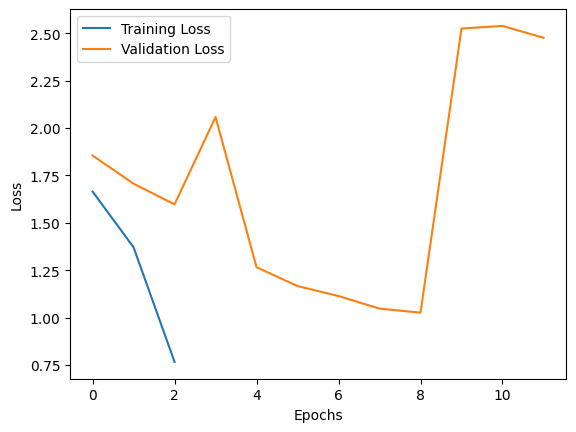

In [56]:
import matplotlib.pyplot as plt
# ログ履歴を確認
log_history = trainer.state.log_history

# トレーニングとバリデーションのロスを取得
train_losses = [log["loss"] for log in log_history if "loss" in log]
val_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]

# 学習曲線をプロット

plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
